In [252]:
import random
from collections.abc import Iterable
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.samplers import RandomGeoSampler, Units


In [253]:
class CustomGeoDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_img_path: Path,
        train_mask_path: Path,
        val_img_path: Path,
        val_mask_path: Path,
        batch_size: int,
        patch_size: int,
        length_train: int,
        length_validate: int,
        num_workers: int = 4,
        train_transform=None,
        val_transform=None,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["train_transform", "val_transform"])

        # Store parameters
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.length_train = length_train
        self.length_validate = length_validate
        self.num_workers = num_workers

        self.train_img_path = train_img_path
        self.train_mask_path = train_mask_path
        self.val_img_path = val_img_path
        self.val_mask_path = val_mask_path
        self.train_transform = train_transform
        self.val_transform = val_transform

        # Initialize datasets and samplers to None
        self.train_dataset = None
        self.val_dataset = None
        self.train_sampler = None
        self.val_sampler = None

    def prepare_data(self):
        """Called only once and on one GPU."""
        # Nothing to download or prepare in this case
        pass

    def setup(self, stage: str = None):
        """Set up datasets for training and validation."""
        if stage == "fit" or stage is None:
            # Setup training data
            train_imgs = RasterDataset(
                paths=str(self.train_img_path), crs="epsg:32633", res=10
            )
            train_masks = RasterDataset(
                paths=str(self.train_mask_path), crs="epsg:32633", res=10
            )
            train_masks.is_image = False
            self.train_dataset = train_imgs & train_masks

            if len(self.train_dataset) == 0:
                raise ValueError("Train dataset is empty!")

            self.train_sampler = RandomGeoSampler(
                dataset=self.train_dataset,
                size=self.patch_size,
                length=self.length_train,
                units=Units.PIXELS,
            )

        if stage == "validate" or stage is None:
            # Setup validation data
            val_imgs = RasterDataset(
                paths=str(self.val_img_path), crs="epsg:32633", res=10
            )
            val_masks = RasterDataset(
                paths=str(self.val_mask_path), crs="epsg:32633", res=10
            )
            val_masks.is_image = False
            self.val_dataset = val_imgs & val_masks

            if len(self.val_dataset) == 0:
                raise ValueError("Validation dataset is empty!")

            self.val_sampler = RandomGeoSampler(
                dataset=self.val_dataset,
                size=self.patch_size,
                length=self.length_validate,
                units=Units.PIXELS,
            )

    def train_dataloader(self):
        """Get train dataloader."""
        if self.train_dataset is None:
            raise ValueError("Training dataset is not initialized. Call setup() first")

        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=self.train_sampler,
            collate_fn=self._collate_fn_train,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        """Get validation dataloader."""
        if self.val_dataset is None:
            raise ValueError(
                "Validation dataset is not initialized. Call setup() first"
            )

        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            sampler=self.val_sampler,
            collate_fn=self._collate_fn_val,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def _collate_fn_train(self, batch):
        """Collate function with train transform applied."""
        return self._apply_transform(batch, self.train_transform)

    def _collate_fn_val(self, batch):
        """Collate function with val transform applied."""
        return self._apply_transform(batch, self.val_transform)

    def _apply_transform(self, batch, transform):
        """Apply the provided transformation to the batch."""
        num_months = 5
        bands_per_month = 6

        augmented_samples = []

        for sample in batch:
            image = sample["image"].clone().detach()
            # mask = sample["mask"].clone().detach()

            # Select a random month
            selected_month = random.randint(0, num_months - 1)  # noqa: S311
            band_start = selected_month * bands_per_month
            band_end = band_start + bands_per_month

            sample["image"] = image[band_start:band_end, :, :]
            # Convert tensors to numpy for augmentation
            image_np = sample["image"].numpy().transpose(1, 2, 0)
            mask_np = sample["mask"].numpy().astype(np.uint8).transpose(1, 2, 0)

            # Apply augmentation if transform is provided
            if transform is not None:
                augmented = transform(image=image_np, mask=mask_np)

                # Ensure 'augmented' outputs are numpy arrays before conversion
                if isinstance(augmented["image"], np.ndarray):
                    sample["image"] = (
                        torch.from_numpy(augmented["image"]).clone().detach()
                    )
                else:
                    sample["image"] = augmented["image"].clone().detach()

                if isinstance(augmented["mask"], np.ndarray):
                    sample["mask"] = (
                        torch.from_numpy(augmented["mask"])
                        .clone()
                        .detach()
                        .permute(2, 0, 1)
                    )
                else:
                    sample["mask"] = augmented["mask"].clone().detach().permute(2, 0, 1)
            else:
                sample["image"] = (
                    torch.tensor(image_np.transpose(2, 0, 1)).clone().detach()
                )
                sample["mask"] = torch.tensor(mask_np).clone().detach().permute(2, 0, 1)

            augmented_samples.append(sample)

        # Remove frozen attributes
        for sample in augmented_samples:
            sample.pop("crs", None)
            sample.pop("bounds", None)

        return stack_samples(augmented_samples)


In [254]:
def normalize_image(image):
    """Min-max normalization per channel."""
    return (image - np.min(image)) / (
        np.max(image) - np.min(image) + 1e-8
    )  # Avoid division by zero


def adaptive_histogram_equalization(image):
    """Apply CLAHE per channel separately."""
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for i in range(image.shape[-1]):  # Apply CLAHE per channel
        image[..., i] = clahe.apply(image[..., i])

    return image / 255.0  # Scale back to [0,1]


def preprocess_image(image):
    """Applies both CLAHE and normalization before Albumentations."""
    image = normalize_image(image)  # Normalize
    image = adaptive_histogram_equalization(image)  # Apply CLAHE
    return image  # Ensure output is just the image array, no dict


def preprocess_fn(image, **kwargs):
    """Wrapper function for Albumentations Lambda, ensures NumPy array output."""
    return preprocess_image(image)  # Only return the transformed image, not a dict


def build_transform(mode="train", plot_batch=False):
    """Build Albumentations transform pipeline."""

    if mode == "train":
        transform = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                # A.Normalize(),  # Albumentations Normalize
                A.Lambda(image=preprocess_fn),  # Apply CLAHE
                A.RandomBrightnessContrast(p=1),
            ],
            additional_targets={"mask": "mask"},
        )

    elif mode == "val":
        transform = A.Compose(
            [
                # A.Normalize(),
                A.Lambda(image=preprocess_fn),  # Apply CLAHE
            ],
            additional_targets={"mask": "mask"},
        )

    return transform


In [255]:
DATA_DIR = Path(
    "/data/P-Prosjekter2/154012_monitoring_natural_habitat_loss_in_norway_with_cop/R/DATA/For_MSc/Project_1"
)

BATCH_SIZE = 2
PATCH_SIZE = 256
LENGTH_TRAIN = 50
LENGTH_VALIDATE = 20

train_path_imgs = DATA_DIR / "new_train_val_scene" / "train"
train_path_masks = DATA_DIR / "new_train_val_truth" / "train"
val_path_imgs = DATA_DIR / "new_train_val_scene" / "val"
val_path_masks = DATA_DIR / "new_train_val_truth" / "val"

In [256]:
train_transform = build_transform(mode="train", plot_batch=True)
val_transform = build_transform(mode="val", plot_batch=True)

In [257]:
data_module = CustomGeoDataModule(
    train_img_path=train_path_imgs,
    train_mask_path=train_path_masks,
    val_img_path=val_path_imgs,
    val_mask_path=val_path_masks,
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    length_train=LENGTH_TRAIN,
    length_validate=LENGTH_VALIDATE,
    train_transform=train_transform,
    val_transform=val_transform,
)

data_module.setup("fit")
data_module.setup("validate")

In [258]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [259]:
def plot_imgs(
    images: Iterable, axs: Iterable, chnls: list[int] | None = None, bright: float = 0.0
):
    # for some reason ruff is complaining about using a "mutable default argument"?
    if chnls is None:  # Initialize the default inside the function
        chnls = [0, 1, 2]

    for img, ax in zip(images, axs, strict=False):
        img = img[:, :, chnls]  # take only the 3 first channels (RGB for May)
        img = img.float()
        img = img

        # Normalize the image to the [0, 1] range using min-max normalization
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min + 1e-8)

        if bright != 0.0:
            img_arr = torch.clamp(bright * img, min=0, max=1).numpy()
        else:
            img_arr = img.numpy()
        rgb = img_arr.transpose(0, 1, 2)

        ax.imshow(rgb)
        ax.axis("off")


def plot_msks(masks: Iterable, axs: Iterable):
    class_labels = ["urban", "cropland", "grass", "forest", "wetland", "water"]
    class_colors = ["red", "yellow", "lime", "green", "purple", "blue"]

    legend_elements = [
        Patch(facecolor=color, edgecolor="black", label=label)
        for color, label in zip(class_colors, class_labels, strict=False)
    ]
    for mask, ax in zip(masks, axs, strict=False):
        ax.imshow(mask.squeeze().numpy(), cmap=ListedColormap(class_colors))
        ax.axis("off")

    axs[0].legend(handles=legend_elements, loc="upper right", title="Classes")


def plot_batch(
    batch: dict,
    bright: float = 0.0,
    cols: int = 4,
    width: int = 5,
    chnls: list[int] | None = None,
):
    # for some reason ruff is complaining about using a "mutable default argument"?
    if chnls is None:  # Initialize the default inside the function
        chnls = [0, 1, 2]
    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())

    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ("image" in batch) and ("mask" in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n // cols + (1 if n % cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols * width, rows * width))

    if ("image" in batch) and ("mask" in batch):
        # plot the images on the even axis
        plot_imgs(
            images=map(lambda x: x["image"], samples),
            axs=axs.reshape(-1)[::2],
            chnls=chnls,
            bright=bright,
        )

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x["mask"], samples), axs=axs.reshape(-1)[1::2])

    else:
        if "image" in batch:
            plot_imgs(
                images=map(lambda x: x["image"], samples),
                axs=axs.reshape(-1),
                chnls=chnls,
                bright=bright,
            )

        elif "mask" in batch:
            plot_msks(masks=map(lambda x: x["mask"], samples), axs=axs.reshape(-1))


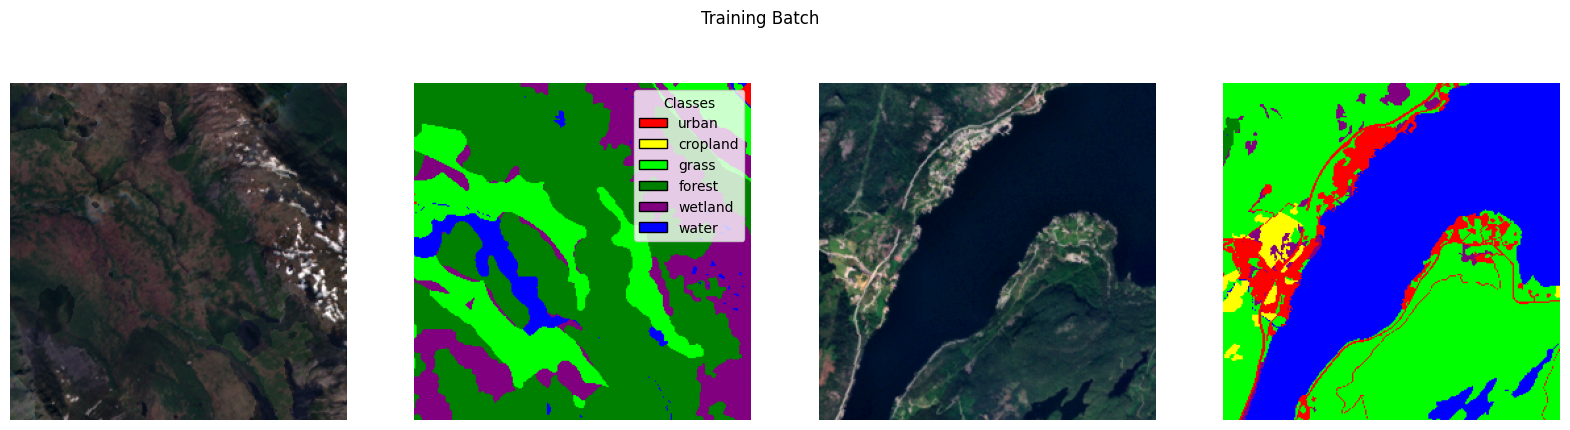

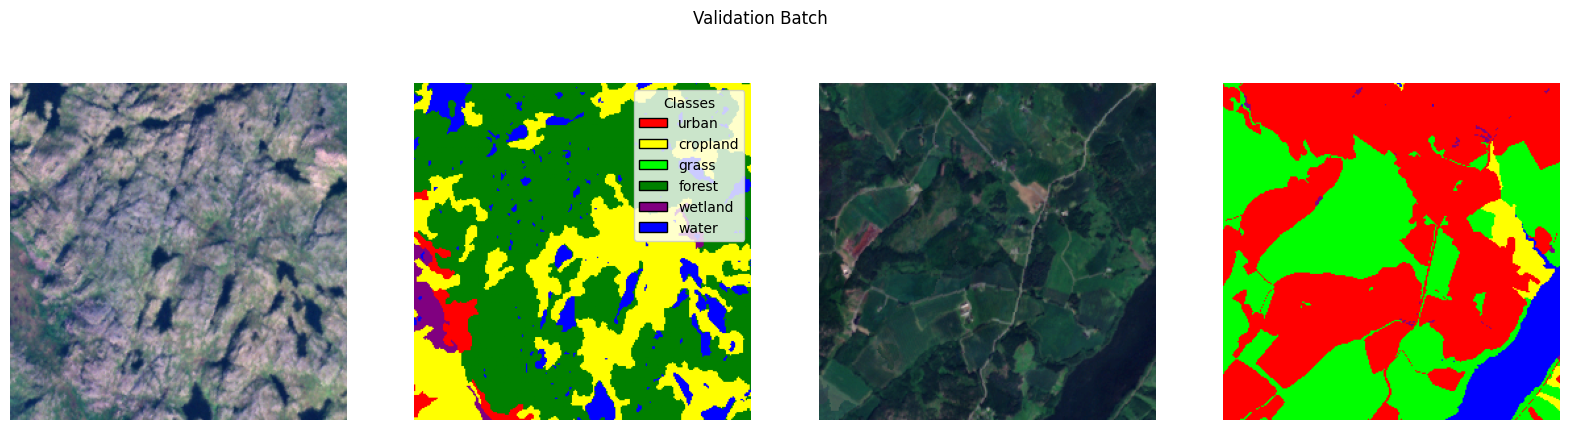

In [265]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

plot_batch(train_batch, cols=4, width=5, chnls=[2, 1, 0])
plt.suptitle("Training Batch")
plt.show()

plot_batch(val_batch, cols=4, width=5, chnls=[2, 1, 0])
plt.suptitle("Validation Batch")
plt.show()
